In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("dst_2014-2023.csv")
print(df.dtypes)

Date    object
Dst      int64
dtype: object


In [3]:
# Mengubah kolom timestamp menjadi datetime jika belum
date = df['Date']
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df

,Dst
Date,
2014-01-01 00:00:00,4
2014-01-01 01:00:00,3
2014-01-01 02:00:00,1
2014-01-01 03:00:00,1
2014-01-01 04:00:00,-1
...,...
2023-12-31 19:00:00,0
2023-12-31 20:00:00,1
2023-12-31 21:00:00,2


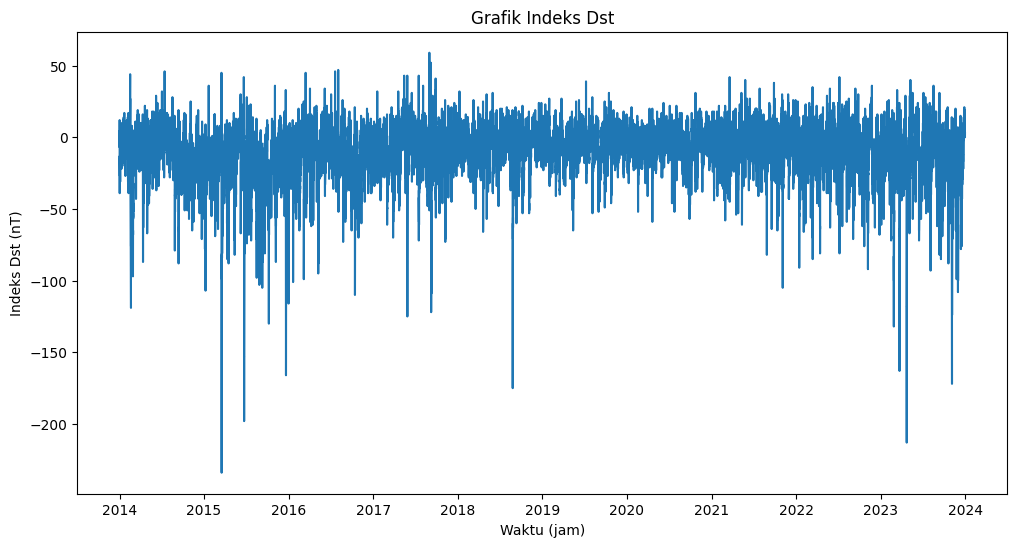

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['Dst'])

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.xticks(rotation=45)

plt.title('Grafik Indeks Dst')
plt.xlabel('Waktu (jam)')
plt.ylabel('Indeks Dst (nT)')
plt.show()

In [6]:
# Statistik deskriptif
print(df.describe())

                Dst
count  87648.000000
mean      -9.580994
std       16.255340
min     -234.000000
25%      -17.000000
50%       -7.000000
75%        1.000000
max       59.000000


In [7]:
dst = df['Dst']

In [9]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, lag=1):
  # Mengubah DataFrame menjadi numpy array
  df_as_np = df.to_numpy()

  # Inisialisasi list kosong untuk fitur (X) dan label (y)
  X = []
  y = []

  # Loop melalui data dengan mempertimbangkan lag
  for i in range(len(df_as_np)-lag):
    # Ambil subset data untuk fitur berdasarkan lag
    row = [[a] for a in df_as_np[i:i+lag]]
    X.append(row)
    # Ambil nilai target, yaitu nilai setelah lag
    label = df_as_np[i+lag]
    y.append(label)
  
   # Fungsi memberikan hasil list X dan y menjadi numpy array
  return np.array(X), np.array(y)

In [10]:
train = int(0.70 * len(dst))
val = int(0.85 * len(dst))

dst_train = dst[:train]
dst_val = dst[train:val]
dst_test = dst[val:]

print(dst_train.shape, dst_val.shape, dst_test.shape)

(61353,) (13147,) (13148,)


In [11]:
WINDOW_SIZE = 3
X_train, y_train = df_to_X_y(dst_train, WINDOW_SIZE)
X_val, y_val = df_to_X_y(dst_val, WINDOW_SIZE)
X_test, y_test = df_to_X_y(dst_test, WINDOW_SIZE)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(61350, 3, 1) (61350,) (13144, 3, 1) (13144,) (13145, 3, 1) (13145,)


In [12]:
train_date = int(0.70 * len(dst) - WINDOW_SIZE)
val_date = int(0.85 * len(dst) - WINDOW_SIZE)

date_train = date[:train_date]
date_val = date[train_date+WINDOW_SIZE:val_date]
date_test = date[val_date+WINDOW_SIZE:-WINDOW_SIZE]

print(date_train.shape, date_val.shape, date_test.shape)

(61350,) (13144,) (13145,)


In [13]:
# Inisialisasi scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scaling data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [18]:
X_train_scaled_2d = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
df_X_train_scaled = pd.DataFrame(X_train_scaled_2d, columns=['x1', 'x2', 'x3'])
df_X_train_scaled

,x1,x2,x3
0,0.863,0.800,0.674
1,0.800,0.674,0.674
2,0.674,0.674,0.549
3,0.674,0.549,0.360
4,0.549,0.360,0.234
...,...,...,...
61345,0.549,0.549,0.611
61346,0.549,0.611,0.611
61347,0.611,0.611,0.423
61348,0.611,0.423,0.297


In [19]:
df_y_train_scaled = pd.DataFrame(data={'Waktu':date_train, 'y':y_train_scaled.flatten()})
df_y_train_scaled

,Waktu,y
0,2014-01-01 00:00:00,0.674
1,2014-01-01 01:00:00,0.549
2,2014-01-01 02:00:00,0.360
3,2014-01-01 03:00:00,0.234
4,2014-01-01 04:00:00,0.171
...,...,...
61345,2020-12-31 01:00:00,0.612
61346,2020-12-31 02:00:00,0.423
61347,2020-12-31 03:00:00,0.297
61348,2020-12-31 04:00:00,0.234


In [20]:
df_train_scaled = pd.concat([df_X_train_scaled, df_y_train_scaled], axis=1)
df_train_scaled = df_train_scaled[['Waktu', 'x1', 'x2', 'x3', 'y']]

In [25]:
pd.options.display.float_format = '{:.3f}'.format
df_train_scaled

,Waktu,x1,x2,x3,y
0,2014-01-01 00:00:00,0.863,0.800,0.674,0.674
1,2014-01-01 01:00:00,0.800,0.674,0.674,0.549
2,2014-01-01 02:00:00,0.674,0.674,0.549,0.360
3,2014-01-01 03:00:00,0.674,0.549,0.360,0.234
4,2014-01-01 04:00:00,0.549,0.360,0.234,0.171
...,...,...,...,...,...
61345,2020-12-31 01:00:00,0.549,0.549,0.611,0.612
61346,2020-12-31 02:00:00,0.549,0.611,0.611,0.423
61347,2020-12-31 03:00:00,0.611,0.611,0.423,0.297
61348,2020-12-31 04:00:00,0.611,0.423,0.297,0.234


In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 64, input_shape = (WINDOW_SIZE, 1), return_sequences = True))
model_lstm.add(LSTM(units = 64, return_sequences = False))
model_lstm.add(Dense(units = 64, activation ='relu'))
model_lstm.add(Dense(units = 1, activation = 'linear'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


In [184]:
cp_lstm = ModelCheckpoint('model_lstm_12_huber.h5', monitor='val_loss', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_lstm.compile(loss='huber', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), 'mae'])

In [185]:
history_lstm = model_lstm.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), batch_size=32, epochs=100, callbacks=[cp_lstm])

Epoch 1/100
1917/1917 [==============================] - 43s 21ms/step - loss: 0.0775 - root_mean_squared_error: 0.4343 - mae: 0.2714 - val_loss: 0.0342 - val_root_mean_squared_error: 0.2659 - val_mae: 0.1883
Epoch 2/100
1917/1917 [==============================] - 42s 22ms/step - loss: 0.0247 - root_mean_squared_error: 0.2266 - mae: 0.1532 - val_loss: 0.0232 - val_root_mean_squared_error: 0.2184 - val_mae: 0.1478
Epoch 3/100
1917/1917 [==============================] - 42s 22ms/step - loss: 0.0226 - root_mean_squared_error: 0.2160 - mae: 0.1465 - val_loss: 0.0228 - val_root_mean_squared_error: 0.2165 - val_mae: 0.1466
Epoch 4/100
1917/1917 [==============================] - 42s 22ms/step - loss: 0.0224 - root_mean_squared_error: 0.2149 - mae: 0.1460 - val_loss: 0.0231 - val_root_mean_squared_error: 0.2176 - val_mae: 0.1475
Epoch 5/100
1917/1917 [==============================] - 41s 22ms/step - loss: 0.0223 - root_mean_squared_error: 0.2142 - mae: 0.1460 - val_loss: 0.0231 - val_root_

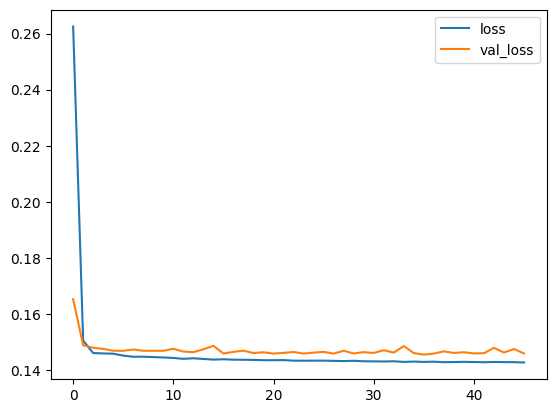

In [19]:
pd.DataFrame(history_lstm.history)[['loss', 'val_loss']].plot();

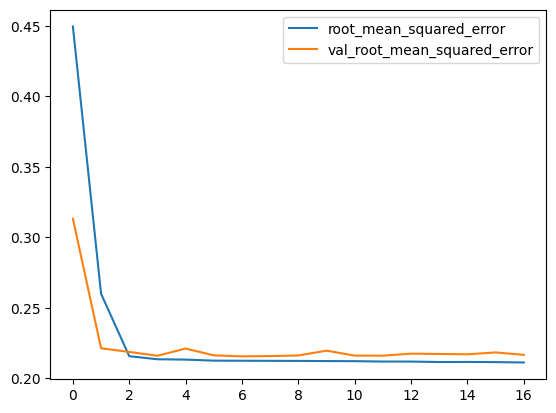

In [85]:
pd.DataFrame(history_lstm.history)[['root_mean_squared_error', 'val_root_mean_squared_error']].plot();

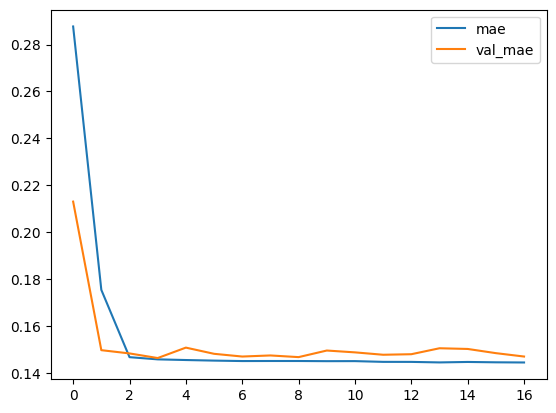

In [86]:
pd.DataFrame(history_lstm.history)[['mae', 'val_mae']].plot();

In [186]:
from tensorflow.keras.models import load_model
model_lstm = load_model('model_lstm_12_huber.h5')

In [187]:
y_train_pred_scaled_lstm = model_lstm.predict(X_train_scaled)
y_train_pred_lstm = scaler_y.inverse_transform(y_train_pred_scaled_lstm)
train_results_lstm = pd.DataFrame(data={'Date':date_train, 'Hasil Prediksi Train Dataset':y_train_pred_lstm.flatten(), 'Indeks Dst Sebenarnya':y_train.flatten()})

1917/1917 [==============================] - 10s 5ms/step


In [188]:
train_results_lstm['Date'] = pd.to_datetime(train_results_lstm['Date'], errors='coerce')
train_results_lstm.set_index('Date', inplace=True)
train_results_lstm

,Hasil Prediksi Train Dataset,Indeks Dst Sebenarnya
Date,,
2014-01-01 00:00:00,6.235402,-1
2014-01-01 01:00:00,-7.574650,-19
2014-01-01 02:00:00,-26.116261,-32
2014-01-01 03:00:00,-34.209213,-39
2014-01-01 04:00:00,-37.834263,-32
...,...,...
2020-12-30 16:00:00,0.141647,0
2020-12-30 17:00:00,-0.295041,-3
2020-12-30 18:00:00,-4.284672,-5


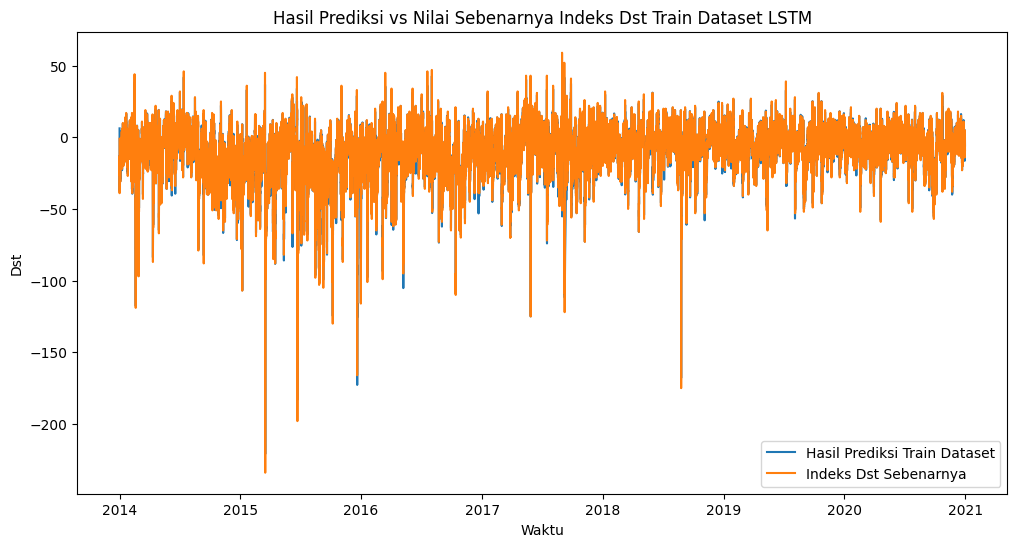

In [189]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_results_lstm.index, train_results_lstm['Hasil Prediksi Train Dataset'], label='Hasil Prediksi Train Dataset')
ax.plot(train_results_lstm.index, train_results_lstm['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Train Dataset LSTM')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

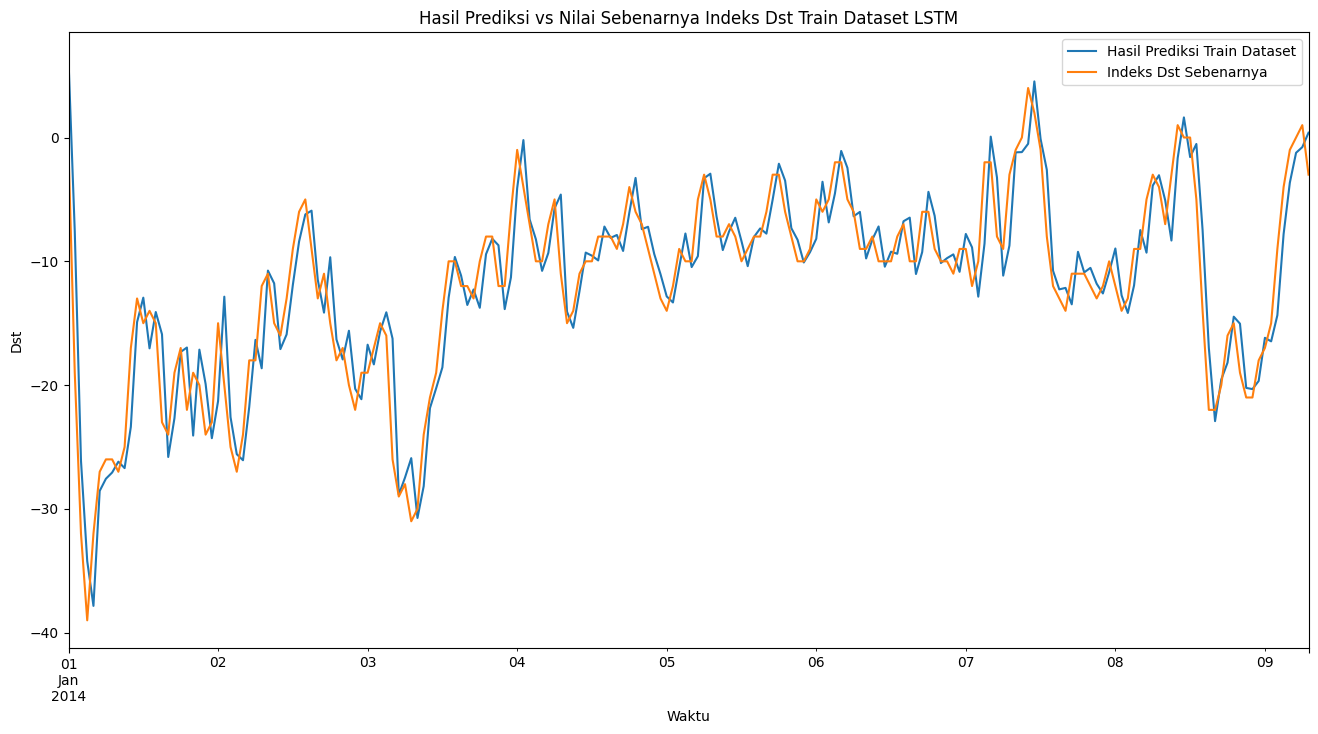

In [190]:
train_results_lstm[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Train Dataset LSTM')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [191]:
y_val_pred_scaled_lstm = model_lstm.predict(X_val_scaled)
y_val_pred_lstm = scaler_y.inverse_transform(y_val_pred_scaled_lstm)
val_results_lstm = pd.DataFrame(data={'Date':date_val,'Hasil Prediksi Validation Dataset':y_val_pred_lstm.flatten(), 'Indeks Dst Sebenarnya':y_val.flatten()})
val_results_lstm

411/411 [==============================] - 3s 8ms/step


,Date,Hasil Prediksi Validation Dataset,Indeks Dst Sebenarnya
61353,2020-12-31 09:00:00,6.019445,5
61354,2020-12-31 10:00:00,3.356885,3
61355,2020-12-31 11:00:00,1.621295,2
61356,2020-12-31 12:00:00,1.395331,-1
61357,2020-12-31 13:00:00,-2.293206,-2
...,...,...,...
74483,2022-07-01 11:00:00,8.352714,13
74484,2022-07-01 12:00:00,13.651130,8
74485,2022-07-01 13:00:00,3.823415,-11
74486,2022-07-01 14:00:00,-20.611595,-29


In [192]:
val_results_lstm['Date'] = pd.to_datetime(val_results_lstm['Date'], errors='coerce')
val_results_lstm.set_index('Date', inplace=True)
val_results_lstm

,Hasil Prediksi Validation Dataset,Indeks Dst Sebenarnya
Date,,
2020-12-31 09:00:00,6.019445,5
2020-12-31 10:00:00,3.356885,3
2020-12-31 11:00:00,1.621295,2
2020-12-31 12:00:00,1.395331,-1
2020-12-31 13:00:00,-2.293206,-2
...,...,...
2022-07-01 11:00:00,8.352714,13
2022-07-01 12:00:00,13.651130,8
2022-07-01 13:00:00,3.823415,-11


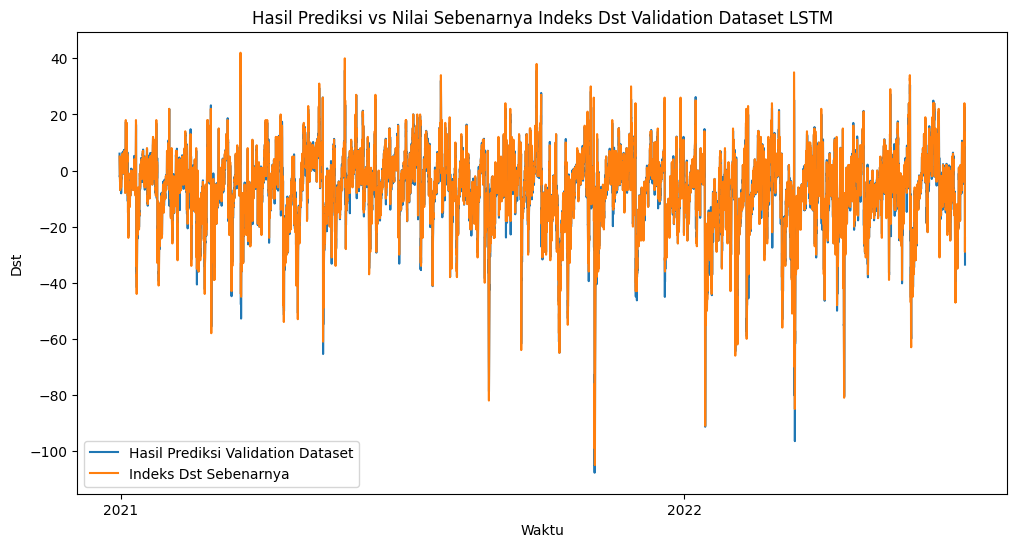

In [193]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(val_results_lstm.index, val_results_lstm['Hasil Prediksi Validation Dataset'], label='Hasil Prediksi Validation Dataset')
ax.plot(val_results_lstm.index, val_results_lstm['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Validation Dataset LSTM')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

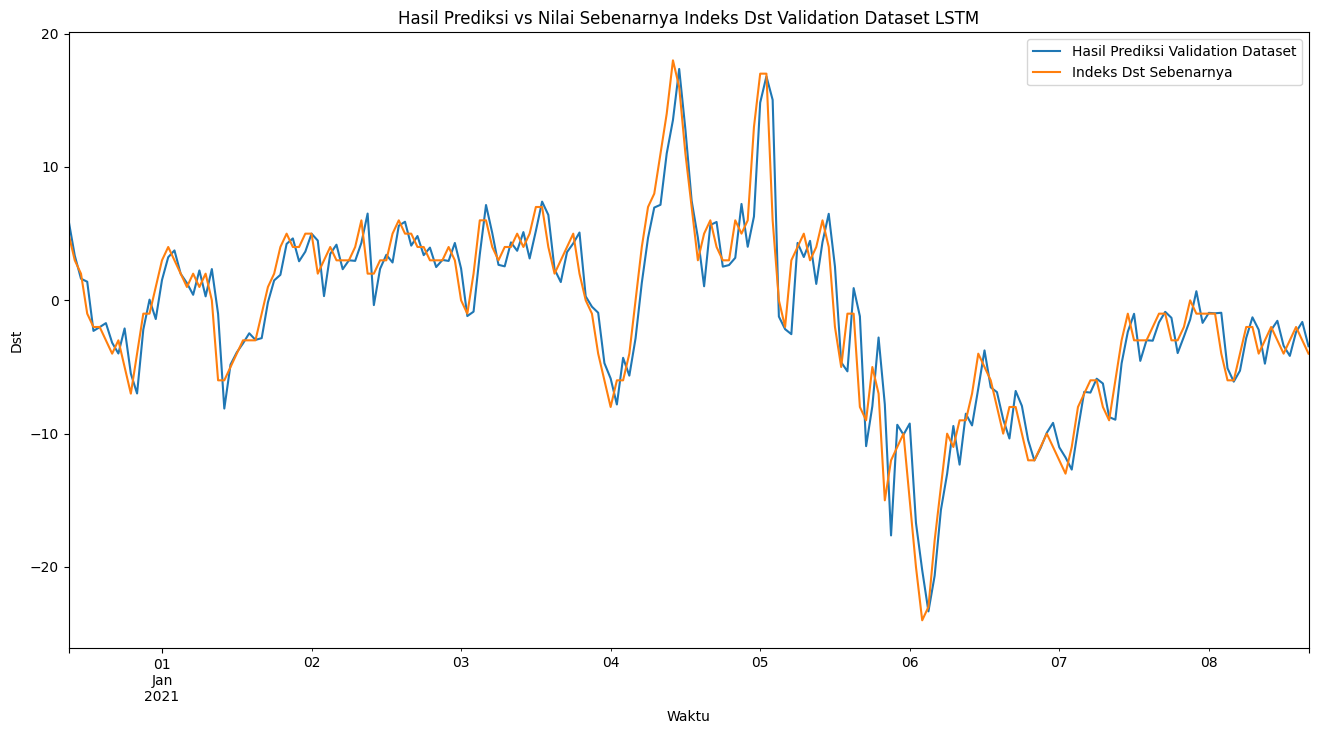

In [194]:
val_results_lstm[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Validation Dataset LSTM')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [195]:
y_test_pred_scaled_lstm = model_lstm.predict(X_test_scaled)
y_test_pred_lstm = scaler_y.inverse_transform(y_test_pred_scaled_lstm)
test_results_lstm = pd.DataFrame(data={'Date':date_test, 'Hasil Prediksi Test Dataset':y_test_pred_lstm.flatten(), 'Indeks Dst Sebenarnya':y_test.flatten()})
test_results_lstm

411/411 [==============================] - 3s 8ms/step


,Date,Hasil Prediksi Test Dataset,Indeks Dst Sebenarnya
74500,2022-07-02 04:00:00,-38.696674,-36
74501,2022-07-02 05:00:00,-33.769108,-34
74502,2022-07-02 06:00:00,-32.924969,-32
74503,2022-07-02 07:00:00,-30.782410,-30
74504,2022-07-02 08:00:00,-28.930782,-30
...,...,...,...
87631,2023-12-31 07:00:00,0.766584,0
87632,2023-12-31 08:00:00,-0.572944,1
87633,2023-12-31 09:00:00,1.787455,2
87634,2023-12-31 10:00:00,2.446647,2


In [196]:
test_results_lstm['Date'] = pd.to_datetime(test_results_lstm['Date'], errors='coerce')
test_results_lstm.set_index('Date', inplace=True)
test_results_lstm

,Hasil Prediksi Test Dataset,Indeks Dst Sebenarnya
Date,,
2022-07-02 04:00:00,-38.696674,-36
2022-07-02 05:00:00,-33.769108,-34
2022-07-02 06:00:00,-32.924969,-32
2022-07-02 07:00:00,-30.782410,-30
2022-07-02 08:00:00,-28.930782,-30
...,...,...
2023-12-31 07:00:00,0.766584,0
2023-12-31 08:00:00,-0.572944,1
2023-12-31 09:00:00,1.787455,2


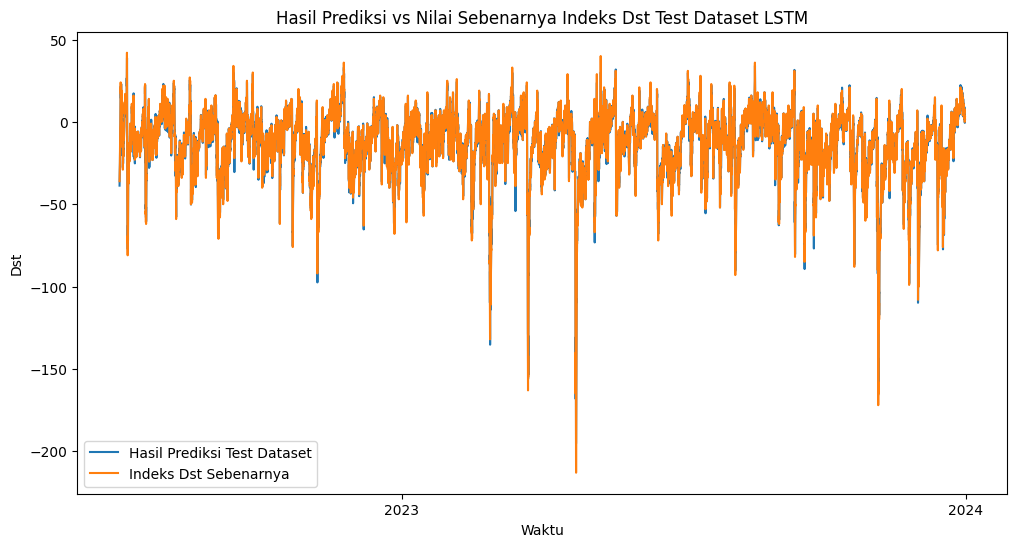

In [197]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_results_lstm.index, test_results_lstm['Hasil Prediksi Test Dataset'], label='Hasil Prediksi Test Dataset')
ax.plot(test_results_lstm.index, test_results_lstm['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Test Dataset LSTM')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

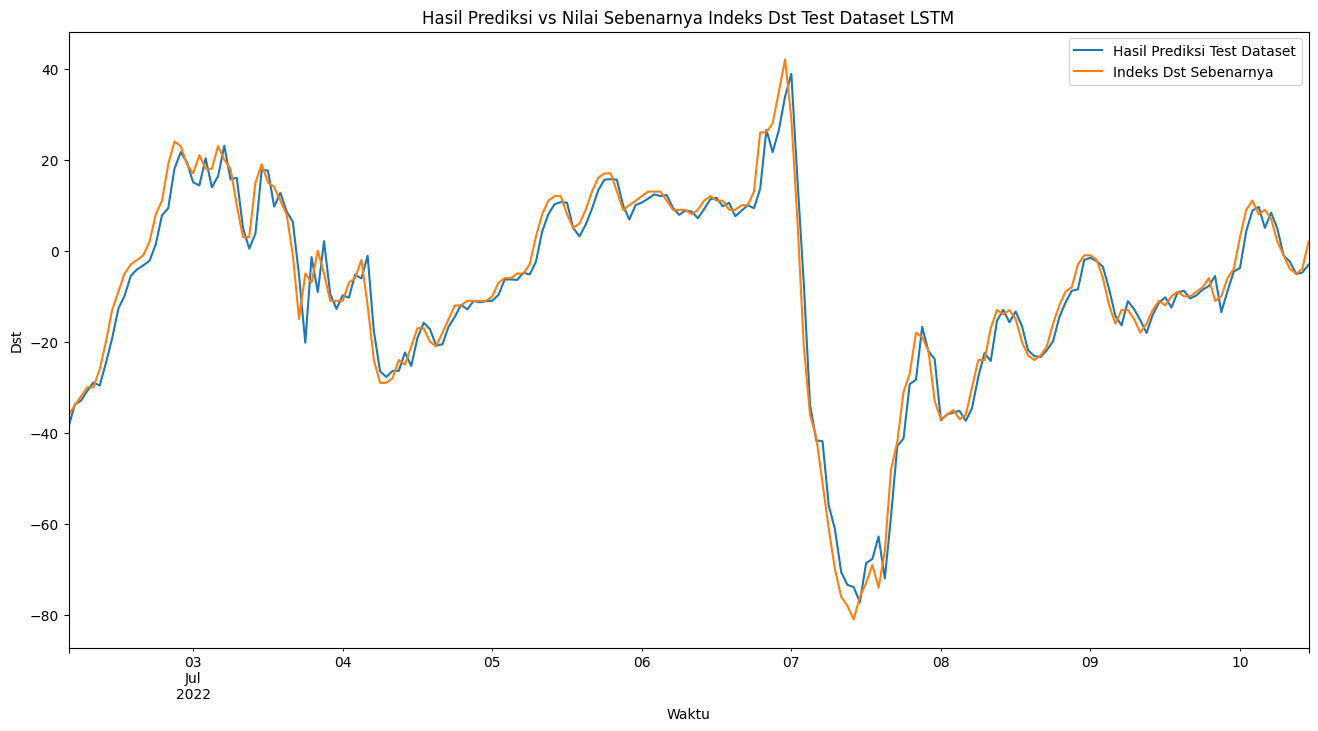

In [198]:
test_results_lstm[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Test Dataset LSTM')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [199]:
# Menghitung metrik pada skala asli
train_mae = mean_absolute_error(y_train, y_train_pred_lstm)
val_mae = mean_absolute_error(y_val, y_val_pred_lstm)
test_mae = mean_absolute_error(y_test, y_test_pred_lstm)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lstm))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lstm))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lstm))

# Menyusun metrik dalam dictionary
metrics_dict = {
    'Metrics': ['MAE', 'RMSE'],
    'Training': [train_mae, train_rmse],
    'Validation': [val_mae, val_rmse],
    'Test': [test_mae, test_rmse]
}

# Membuat DataFrame dari dictionary metrik
metrics_df = pd.DataFrame(metrics_dict)

# Menampilkan tabel metrik
print(metrics_df)

  Metrics  Training  Validation      Test
0     MAE  2.258574    2.327379  2.825558
1    RMSE  3.302996    3.410687  4.174196


In [20]:
model_gru = Sequential()
model_gru.add(GRU(units = 64, input_shape = (WINDOW_SIZE, 1), return_sequences = True))
model_gru.add(GRU(units = 64, return_sequences = False))
model_gru.add(Dense(units = 64, activation ='relu' ))
model_gru.add(Dense(units = 1, activation = 'linear'))

model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 64)             12864     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 42,049
Trainable params: 42,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp_gru = ModelCheckpoint('model_gru_6_huber.h5', monitor='val_loss', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_gru.compile(loss='huber', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), 'mae'])

In [22]:
history_gru = model_gru.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), batch_size=32, epochs=100, callbacks=[cp_gru])

Epoch 1/100
1918/1918 [==============================] - 24s 11ms/step - loss: 0.0503 - root_mean_squared_error: 0.3409 - mae: 0.2148 - val_loss: 0.0248 - val_root_mean_squared_error: 0.2259 - val_mae: 0.1533
Epoch 2/100
1918/1918 [==============================] - 17s 9ms/step - loss: 0.0226 - root_mean_squared_error: 0.2160 - mae: 0.1458 - val_loss: 0.0227 - val_root_mean_squared_error: 0.2160 - val_mae: 0.1486
Epoch 3/100
1918/1918 [==============================] - 20s 10ms/step - loss: 0.0221 - root_mean_squared_error: 0.2131 - mae: 0.1446 - val_loss: 0.0229 - val_root_mean_squared_error: 0.2167 - val_mae: 0.1475
Epoch 4/100
1918/1918 [==============================] - 20s 11ms/step - loss: 0.0219 - root_mean_squared_error: 0.2122 - mae: 0.1442 - val_loss: 0.0233 - val_root_mean_squared_error: 0.2184 - val_mae: 0.1490
Epoch 5/100
1918/1918 [==============================] - 24s 12ms/step - loss: 0.0219 - root_mean_squared_error: 0.2116 - mae: 0.1441 - val_loss: 0.0227 - val_root_m

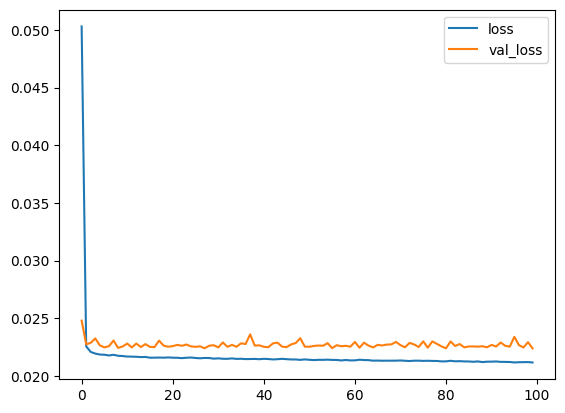

In [23]:
pd.DataFrame(history_gru.history)[['loss', 'val_loss']].plot();

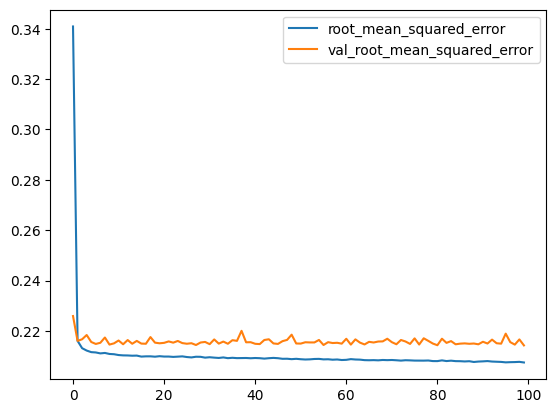

In [24]:
pd.DataFrame(history_gru.history)[['root_mean_squared_error', 'val_root_mean_squared_error']].plot();

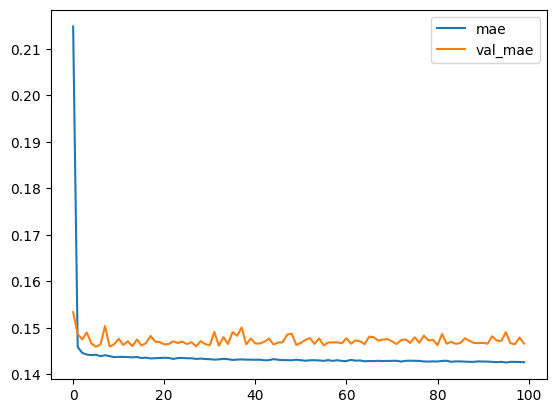

In [25]:
pd.DataFrame(history_gru.history)[['mae', 'val_mae']].plot();

In [26]:
from tensorflow.keras.models import load_model
model_gru = load_model('model_gru_6_huber.h5')

In [27]:
y_train_pred_scaled_gru = model_gru.predict(X_train_scaled)
y_train_pred_gru = scaler_y.inverse_transform(y_train_pred_scaled_gru)
train_results_gru = pd.DataFrame(data={'Date':date_train, 'Hasil Prediksi Train Dataset':y_train_pred_gru.flatten(), 'Indeks Dst Sebenarnya':y_train.flatten()})

1918/1918 [==============================] - 4s 2ms/step


In [28]:
train_results_gru['Date'] = pd.to_datetime(train_results_gru['Date'], errors='coerce')
train_results_gru.set_index('Date', inplace=True)
train_results_gru

,Hasil Prediksi Train Dataset,Indeks Dst Sebenarnya
Date,,
2014-01-01 00:00:00,-4.835429,-6
2014-01-01 01:00:00,-6.119997,-7
2014-01-01 02:00:00,-6.640415,-5
2014-01-01 03:00:00,-3.709992,3
2014-01-01 04:00:00,4.949954,12
...,...,...
2020-12-30 22:00:00,0.178906,0
2020-12-30 23:00:00,-0.283189,-3
2020-12-31 00:00:00,-4.346922,-5


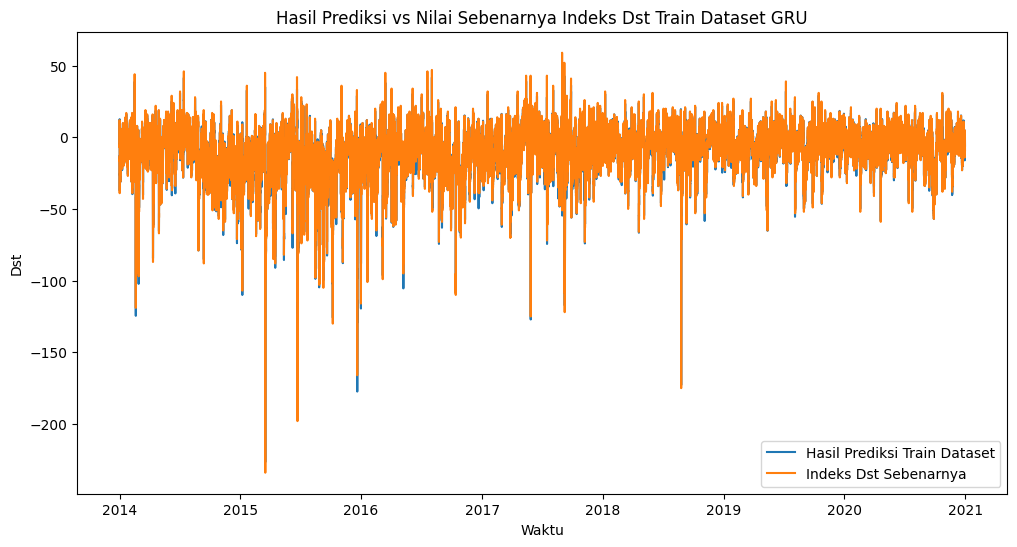

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_results_gru.index, train_results_gru['Hasil Prediksi Train Dataset'], label='Hasil Prediksi Train Dataset')
ax.plot(train_results_gru.index, train_results_gru['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Train Dataset GRU')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

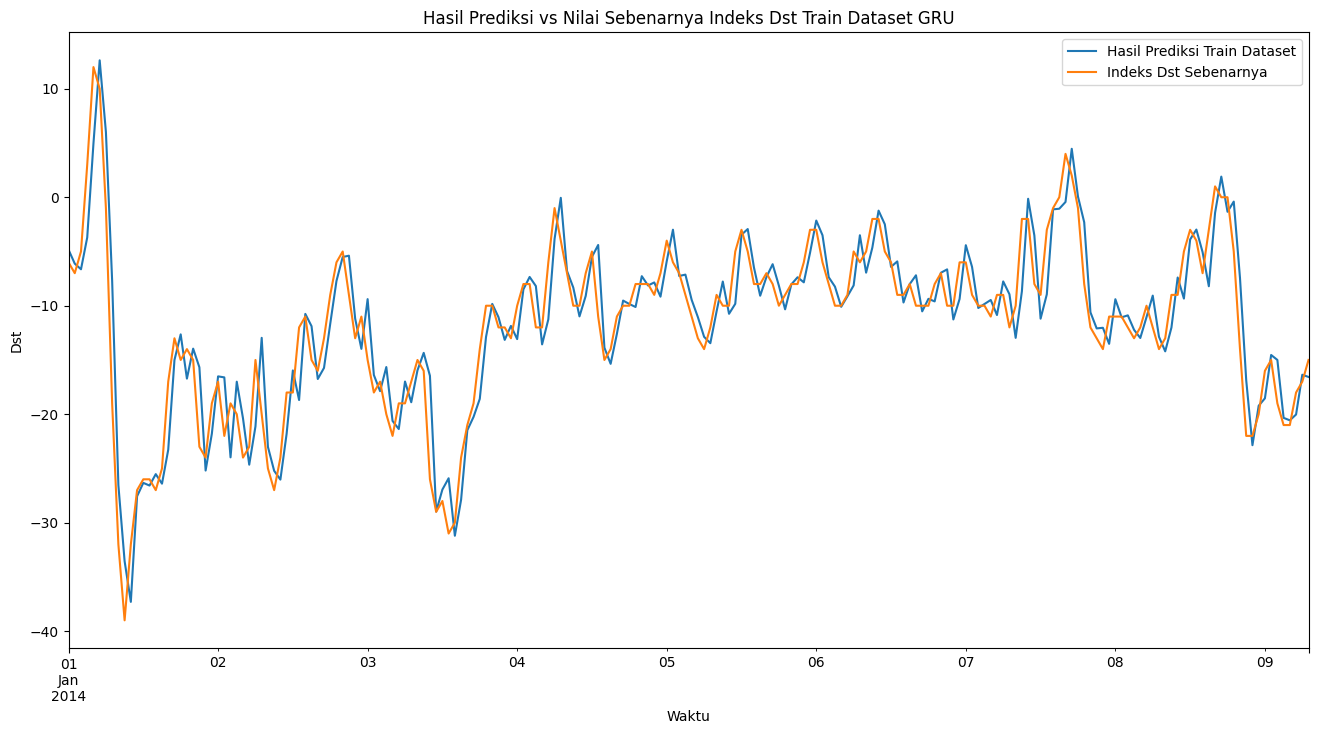

In [30]:
train_results_gru[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Train Dataset GRU')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [31]:
y_val_pred_scaled_gru = model_gru.predict(X_val_scaled)
y_val_pred_gru = scaler_y.inverse_transform(y_val_pred_scaled_gru)
val_results_gru = pd.DataFrame(data={'Date':date_val,'Hasil Prediksi Validation Dataset':y_val_pred_gru.flatten(), 'Indeks Dst Sebenarnya':y_val.flatten()})
val_results_gru

411/411 [==============================] - 1s 2ms/step


,Date,Hasil Prediksi Validation Dataset,Indeks Dst Sebenarnya
61353,2020-12-31 09:00:00,-1.310985,-2
61354,2020-12-31 10:00:00,-2.583636,-2
61355,2020-12-31 11:00:00,-2.228586,-2
61356,2020-12-31 12:00:00,-2.112766,-1
61357,2020-12-31 13:00:00,-0.643565,3
...,...,...,...
74489,2022-07-01 17:00:00,8.103446,13
74490,2022-07-01 18:00:00,13.163457,8
74491,2022-07-01 19:00:00,3.880077,-11
74492,2022-07-01 20:00:00,-19.134602,-29


In [32]:
val_results_gru['Date'] = pd.to_datetime(val_results_gru['Date'], errors='coerce')
val_results_gru.set_index('Date', inplace=True)
val_results_gru

,Hasil Prediksi Validation Dataset,Indeks Dst Sebenarnya
Date,,
2020-12-31 09:00:00,-1.310985,-2
2020-12-31 10:00:00,-2.583636,-2
2020-12-31 11:00:00,-2.228586,-2
2020-12-31 12:00:00,-2.112766,-1
2020-12-31 13:00:00,-0.643565,3
...,...,...
2022-07-01 17:00:00,8.103446,13
2022-07-01 18:00:00,13.163457,8
2022-07-01 19:00:00,3.880077,-11


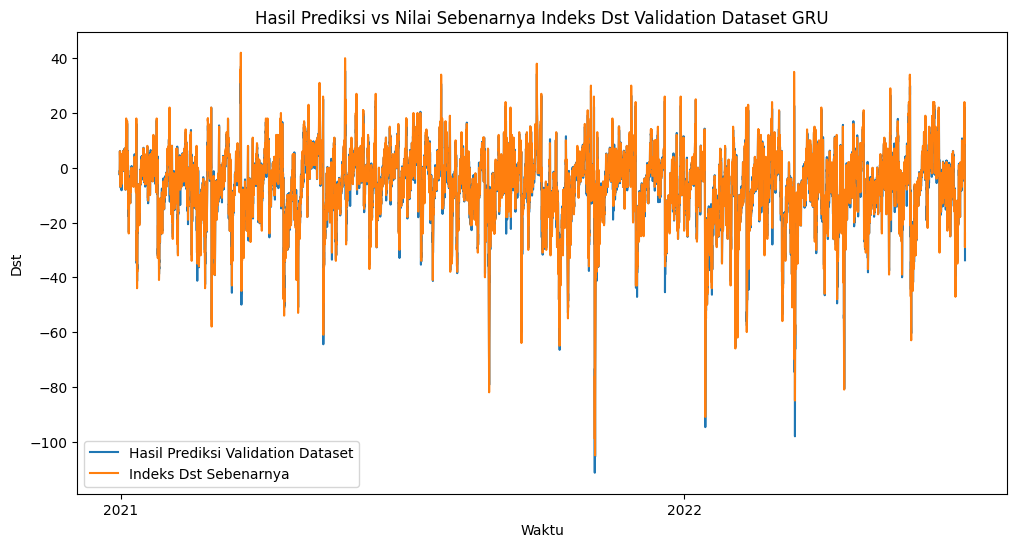

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(val_results_gru.index, val_results_gru['Hasil Prediksi Validation Dataset'], label='Hasil Prediksi Validation Dataset')
ax.plot(val_results_gru.index, val_results_gru['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Validation Dataset GRU')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

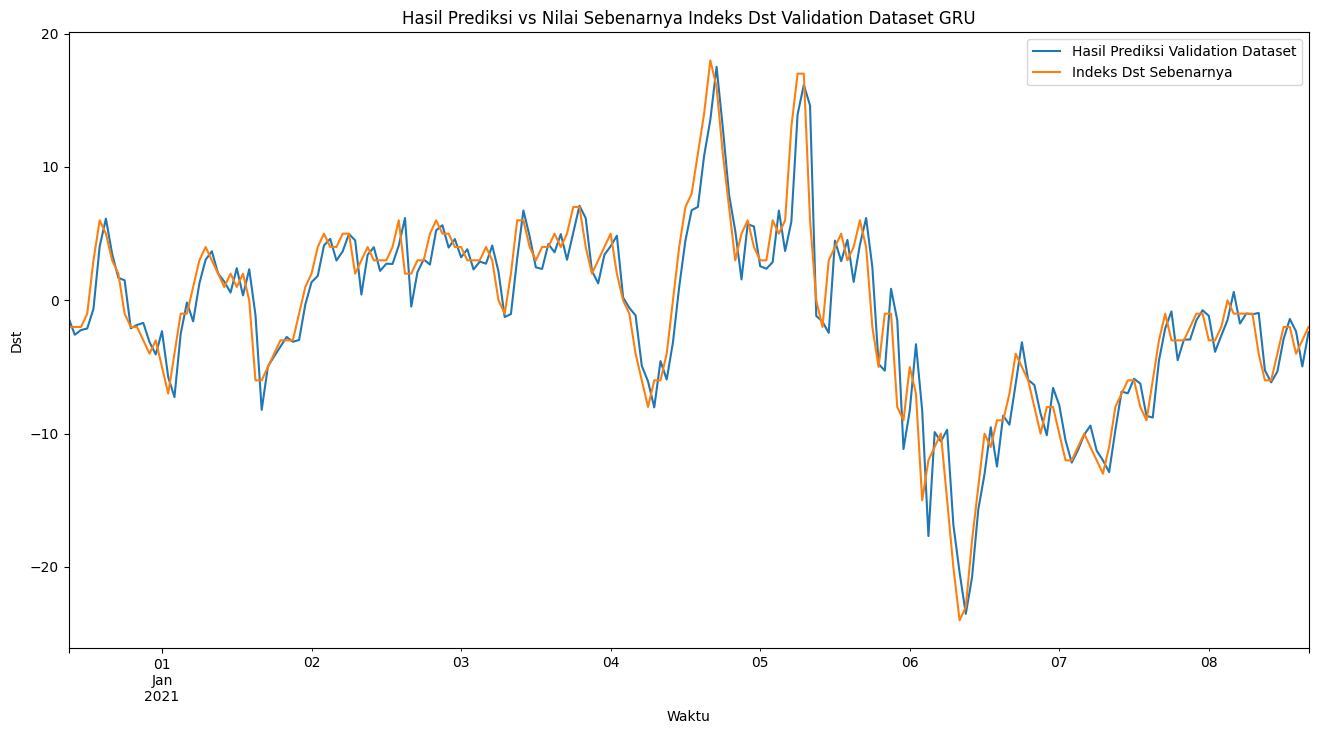

In [34]:
val_results_gru[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Validation Dataset GRU')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [35]:
y_test_pred_scaled_gru = model_gru.predict(X_test_scaled)
y_test_pred_gru = scaler_y.inverse_transform(y_test_pred_scaled_gru)
test_results_gru = pd.DataFrame(data={'Date':date_test, 'Hasil Prediksi Test Dataset':y_test_pred_gru.flatten(), 'Indeks Dst Sebenarnya':y_test.flatten()})
test_results_gru

411/411 [==============================] - 1s 2ms/step


,Date,Hasil Prediksi Test Dataset,Indeks Dst Sebenarnya
74500,2022-07-02 04:00:00,-50.983185,-54
74501,2022-07-02 05:00:00,-52.187660,-54
74502,2022-07-02 06:00:00,-50.915310,-52
74503,2022-07-02 07:00:00,-48.562691,-48
74504,2022-07-02 08:00:00,-44.503841,-44
...,...,...,...
87637,2023-12-31 13:00:00,0.594058,0
87638,2023-12-31 14:00:00,-0.700748,1
87639,2023-12-31 15:00:00,1.454198,2
87640,2023-12-31 16:00:00,2.194289,2


In [36]:
test_results_gru['Date'] = pd.to_datetime(test_results_gru['Date'], errors='coerce')
test_results_gru.set_index('Date', inplace=True)
test_results_gru

,Hasil Prediksi Test Dataset,Indeks Dst Sebenarnya
Date,,
2022-07-02 04:00:00,-50.983185,-54
2022-07-02 05:00:00,-52.187660,-54
2022-07-02 06:00:00,-50.915310,-52
2022-07-02 07:00:00,-48.562691,-48
2022-07-02 08:00:00,-44.503841,-44
...,...,...
2023-12-31 13:00:00,0.594058,0
2023-12-31 14:00:00,-0.700748,1
2023-12-31 15:00:00,1.454198,2


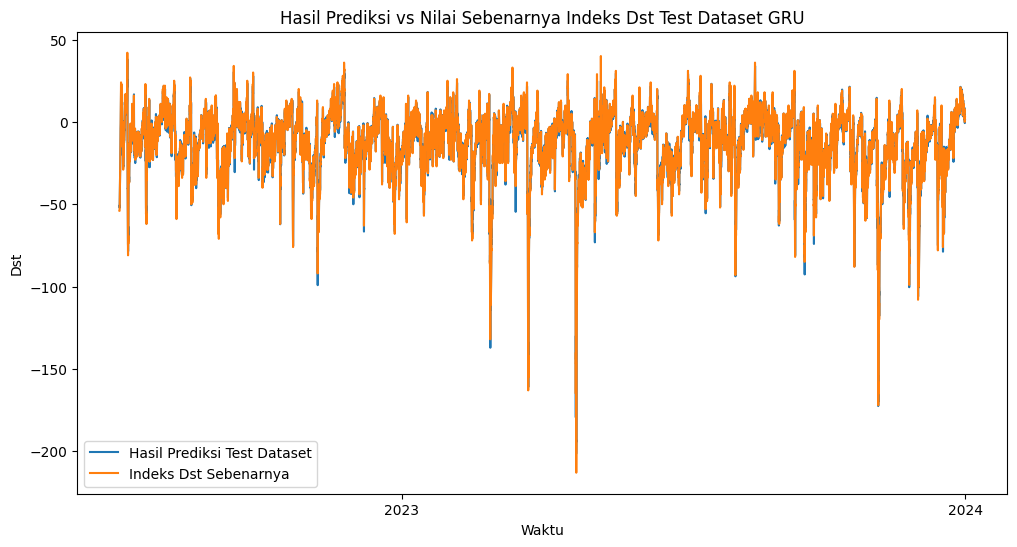

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_results_gru.index, test_results_gru['Hasil Prediksi Test Dataset'], label='Hasil Prediksi Test Dataset')
ax.plot(test_results_gru.index, test_results_gru['Indeks Dst Sebenarnya'], label='Indeks Dst Sebenarnya')

# Mengatur locator untuk sumbu x setiap tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Waktu')
plt.ylabel('Indeks Dst')
plt.title('Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Test Dataset GRU')
plt.ylabel('Dst')
ax.legend()
plt.show()

Text(0.5, 0, 'Waktu')

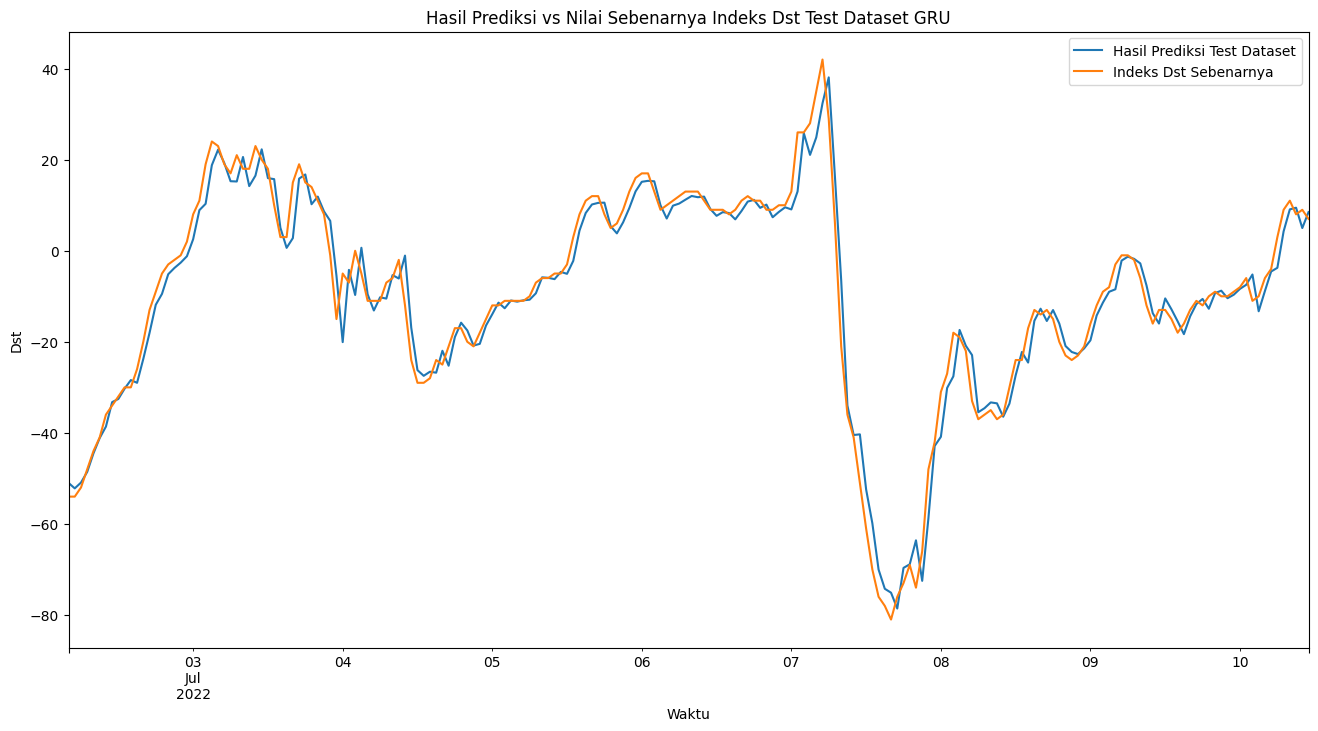

In [38]:
test_results_gru[:200].plot(figsize=(16, 8))
plt.title(f'Hasil Prediksi vs Nilai Sebenarnya Indeks Dst Test Dataset GRU')
plt.ylabel('Dst')
plt.xlabel('Waktu')

In [40]:
# Menghitung metrik pada skala asli
train_mae = mean_absolute_error(y_train, y_train_pred_gru)
val_mae = mean_absolute_error(y_val, y_val_pred_gru)
test_mae = mean_absolute_error(y_test, y_test_pred_gru)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gru))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_gru))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gru))

# Menyusun metrik dalam dictionary
metrics_dict = {
    'Metrics': ['MAE', 'RMSE'],
    'Training': [train_mae, train_rmse],
    'Validation': [val_mae, val_rmse],
    'Test': [test_mae, test_rmse]
}

# Membuat DataFrame dari dictionary metrik
metrics_df = pd.DataFrame(metrics_dict)

# Menampilkan tabel metrik
print(metrics_df)

  Metrics  Training  Validation      Test
0     MAE  2.265429    2.331751  2.837027
1    RMSE  3.302099    3.408031  4.163853
